### Load Data & Pivot Medical Test Results to Wide Format

In [20]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/raw/healthcare_analytics_dataset.csv")

# Filter only medical test data
test_df = df[["patient_id", "medical_test_type", "test_result_value"]].dropna()

# Pivot test types to columns: one row per patient
df_tests = df.pivot_table(
    index="patient_id",
    columns="medical_test_type",
    values="test_result_value",
    aggfunc="mean",  # In case patient has multiple of the same test
).reset_index()

# Rename columns for clarity
df_tests.columns.name = None  # remove column group name
df_tests = df_tests.rename(
    columns={
        "Blood test": "blood_test",
        "CT Scan": "ct_scan",
        "MRI": "mri",
        "Ultrasound": "ultrasound",
        "X-ray": "xray",
    }
)

df_tests.head()

,patient_id,Blood Test,ct_scan,mri,ultrasound,xray
0,PID0001,NaN,NaN,NaN,6.62,NaN
1,PID0002,NaN,NaN,10.62,NaN,NaN
2,PID0003,8.50,NaN,NaN,NaN,NaN
3,PID0004,NaN,NaN,NaN,NaN,2.86
4,PID0005,3.82,NaN,NaN,NaN,NaN


### Standardize & Cluster (KMeans)

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Drop patient_id for clustering
X = df_tests.drop(columns="patient_id").copy()

# Fill missing test values with column means
X_filled = X.fillna(X.mean(numeric_only=True))

# Standardize and cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

kmeans = KMeans(n_clusters=3, random_state=42)
df_tests["cluster"] = kmeans.fit_predict(X_scaled)

print(df_tests[["patient_id", "cluster"]].head())

  patient_id  cluster
0    PID0001        1
1    PID0002        1
2    PID0003        1
3    PID0004        2
4    PID0005        0


### Save the Clustered Data

In [26]:
df_tests.to_csv("../data/processed/cleaned/test_cluster_results.csv", index=False)
print("✅ Saved to /data/processed/cleanedtest_cluster_results.csv")

✅ Saved to /data/processed/cleanedtest_cluster_results.csv


### Visualize with Pairplot

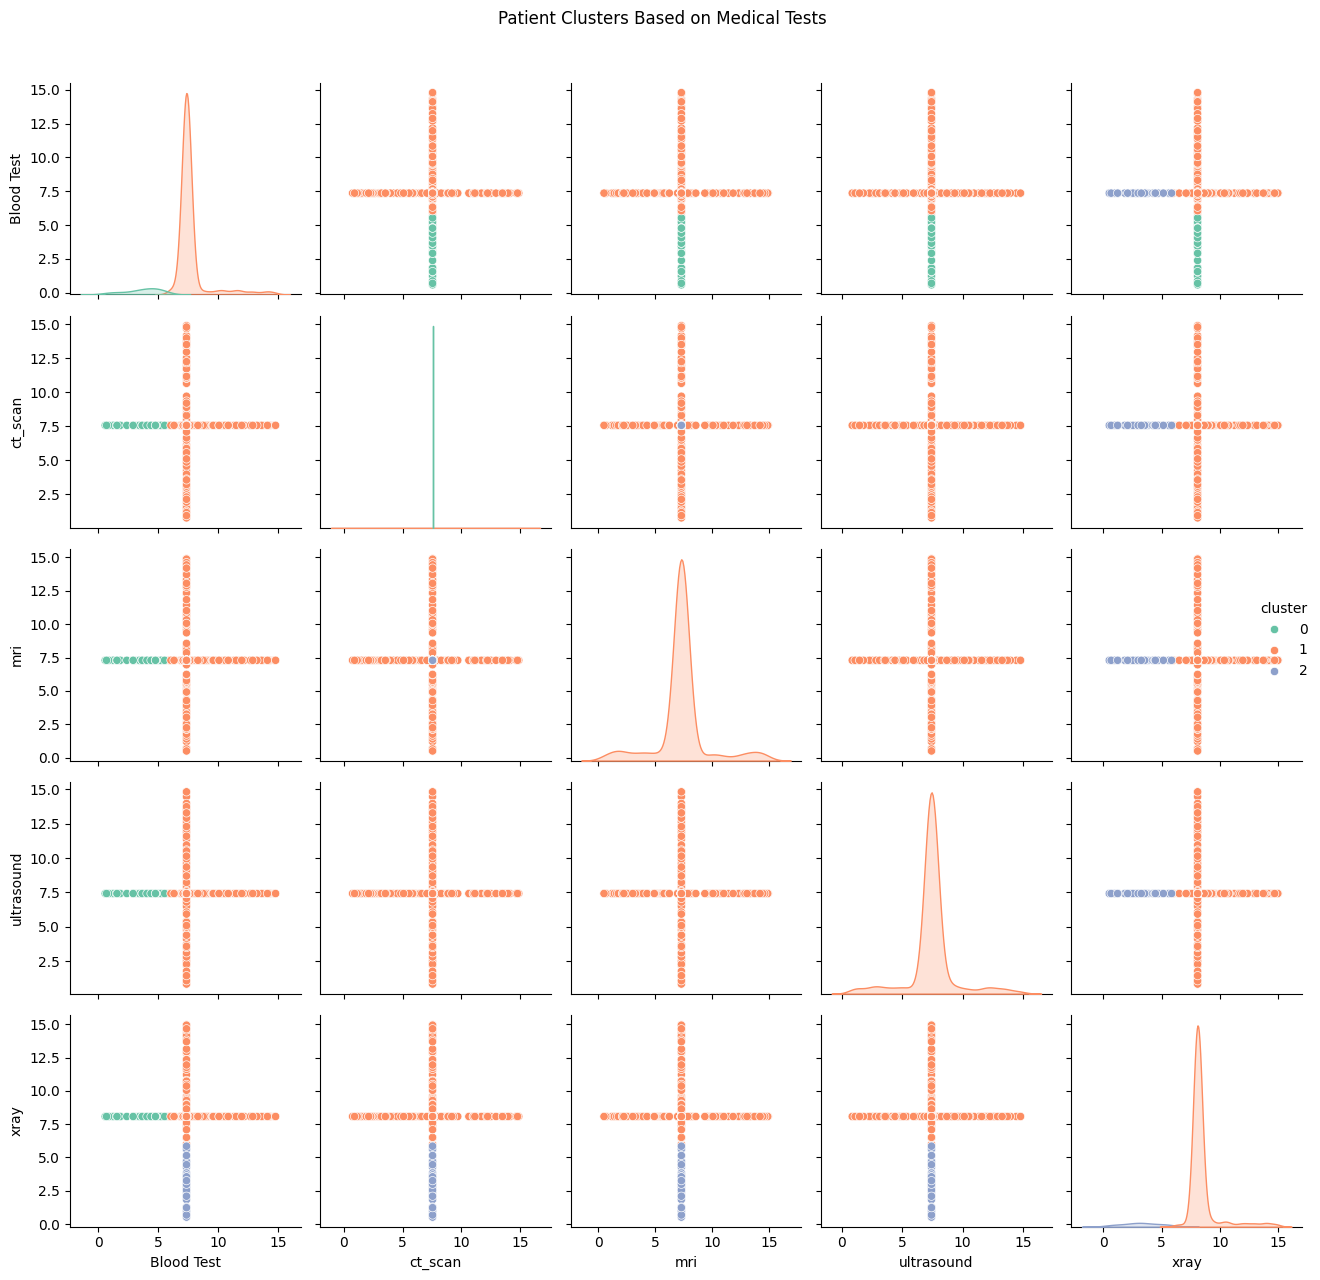

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create output directory if needed
os.makedirs("../visuals/plots", exist_ok=True)

# Add cluster back to X_filled for plotting
X_filled["cluster"] = df_tests["cluster"]

# Plot
sns.pairplot(X_filled, hue="cluster", palette="Set2")
plt.suptitle("Patient Clusters Based on Medical Tests", y=1.02)
plt.tight_layout()
plt.savefig("../visuals/plots/medical_test_clusters.png")
plt.show()